# Análisis exploratorio del IFN3 y 4 en Aragón

Selección de los mejores estadillos para el entrenamiendo de modelos de clasificación. Es previsible que se seleccionen más puntos de arbolado que de matorral, pues todas las parcelas del inventario se localizaron sobre superficie arbolada.

Las estructuras del IFN3 e IFN4 son distintas a la de su predecesor. Los datos se guardan en dos bases de datos principales en formato `accdb` (IFN3) y `mdb` (IFN4). Una BBDD para los datos de campo (prefijo Ifn) y otra para los datos del cálculo de existencias (prefigo Sig).

In [1]:
from pathlib import Path
import sys
import pandas as pd # type: ignore
import geopandas as gpd
import matplotlib.pyplot as plt # type: ignore

# ROOT = r"D:\iranzo\doctorado_v2\classification"
ROOT = r"C:\copia_seguridad\doctorado_v2\classification"
# NFI classes
module_path = Path(ROOT, "Python")
sys.path.append(str(module_path))
from ifn import Modern # type: ignore

In [7]:
# Erase the leading 0s in Especia column
def erase_zeros(df, col):
    """Remove leading zeros and avoid '00' becomes an empty string"""
    return df[col].str.lstrip('0').replace('', '0').astype("int16")

En lugar de incluir el conjunto de la información de todas las bases de datos por provincia en un mismo `pandas.DataFrame`, se ha desarrollado una clase con la que ir realizando consultas a las tablas seleccionadas por provincia y juntar **solo el resultado de las consultas**.

In [120]:
ifn3 = Modern(Path(ROOT, r"data\labels\ifn\ifn3"))
ifn4 = Modern(Path(ROOT, r"data\labels\ifn\ifn4"))

## Ifn / PCParcelas

In [121]:
cols = [
    'Provincia',
    'Estadillo',
    'Cla',
    'Subclase',
    'FechaFin',
    'Tipo',
    'FccTot',
    'FccArb',
    'Nivel1',
    'Nivel2',
    'Nivel3'
]

pcparcelas_3 = ifn3.open('PCParcelas', cols=cols)
pcparcelas_4 = ifn4.open('PCParcelas', cols=cols)

### Fracción de cabida cubierta

Los datos de FCC se dividen entra la fracción total (contando el matorral) y la fracción arbórea (tan solo la vegetación arbórea). No se explica en el documentador de las bases de datos.

¿Qué valor de FCC es el que aparece en el IFN2, el de FccTot o el de FccArb? En los materiales y métodos del IFN2 se describe FCC como:

> el cociente de dividir la superficie proyectada ortogonalmente sobre el suelo de todas las **copas de los árboles** de la parcela por el área de dicha parcela.

Por lo tanto, todo parece indicar que se asocia con la medida de FccArb del IFN3 y 4.

> Se utiliza la columna FccArb para seleccionar las parcelas idóneas de tipo forestal para mantener la coherencia con el procedimiento llevado a cabo en el IFN2.

### Clase

Una característica novedosa del IFN3 con respecto al IFN2 son las nuevas columnas "Cla" y "Subclase". Los operadores del IFN3 intentaron revisitar las parcelas del IFN2 para realizar los nuevos estadillos.

La columna "Cla" puede contener dos valores:

- `N` Parcela levantada por primera vez en el IFN-3.
- `A` Parcelas levantadas en el IFN-2/3 que han vuelto a apearse.

La columna "Subclase" contiene información adicional sobre el levantamiento. Si la parcela es "Cla = A", esta columna puede contener los siguientes valores:

- `1` Parcela bien localizada.
- `3` Parcela con localizaciones en diferentes teselas del mapa topográfico en IFN2 e IFN3. En estos casos, se cumplimentan **dos estadillos** para la misma parcela:
  - `3C` Levantados en el punto donde se encuentre el rejón del IFN2. Útil al **comparar inventarios**.
  - `3E` Se levantan en el emplazamiento del IFN3. Parcelas para el cálculo de existencias actuales.
- `4` No se localiza el rejón del IFN2.
  - `4C` No localizado por **cambios totales en la cubierta forestal** de la tesela que contiene la parcela. Puede ser por la pérdida total de la masa del IFN2 o por la incorporación de nueva masa forestal inexistente en IFN2.
- `6C` Misma situación que en `4C`, donde se dan a la vez los dos supuestos (pérdida de la masa forestal del IFN2 e incorporación de una nueva).

> De las dos clases 3, ¿cuál es la que aparece en las coordenadas proporcionadas por el ministerio?

Al no haber ningún estadillo repetido en ninguna de las provincias, se ha entendido que se corresponden a la 3C de cara a favorecer la comparación entre inventarios.

> ¿Y el IFN4 no levanta los puntos en función de los del IFN3? ¿Utiliza los A3C o los A3E?

Se filtran en el IFN4 los estadillos con la clase A por la subclase A1, con rejones bien localizados e implantados.

Es posible que los rejones del IFN2 y del IFN3 estén muy próximos entre sí, por lo que se ha optado por considerarlos iguales (con la misma posición).


In [22]:
print(pcparcelas_3.groupby(['Cla', 'Subclase']).count()['Estadillo'])

Cla  Subclase
A    1           4186
     3C           564
     3E           564
     4            583
     4C            99
     6C            30
N    N            504
Name: Estadillo, dtype: int64


En el IFN3, son 4186 las parcelas bien localizadas (A), pero existen otras muchas con problemas en la localización (3C, 3E, 4, 4C, 6C). Son 504 las parcelas nuevas en el IFN3 con respecto al IFN2.

In [23]:
print(pcparcelas_4.groupby(['Cla', 'Subclase']).count()['Estadillo'])

Cla  Subclase
A    1           4011
     4            517
     4C            29
     6C            54
N    N            392
Name: Estadillo, dtype: int64


Ver dónde están los estadillos duplicados.

In [ ]:
def check_duplicate_cla(df):
    """Select possible rows duplicated due to Cla and Subclase"""
    duplicates = df.duplicated(subset=['Estadillo', 'Provincia'], keep=False)
    print(df[duplicates].groupby(['Cla', 'Subclase']).count()['Estadillo'])

In [127]:
check_duplicate_cla(pcparcelas_3)

Cla  Subclase
A    3C          564
     3E          564
Name: Estadillo, dtype: int64


In [128]:
check_duplicate_cla(pcparcelas_4)

Series([], Name: Estadillo, dtype: int64)


Solo hay estadillos duplicados por motivo de la Clase en el IFN3. Seleccionar todos menos la Subclase 3E.

In [129]:
pcparcelas_3 = pcparcelas_3.query("Subclase != '3E'")

### Años

La columna de PCParcelas `FechaFin` contiene la fecha de finalización del apeo de la parcela. La fecha tiene un formato (día/mes/año), y al convertir el resultado de la extracción a un `pandas.DataFrame` se guardan como un objeto `datetime64`.

A continuación se muestran solo los años, con el objetivo de comprobar los años de realización en Aragón.

In [97]:
pcparcelas_3.groupby(['Provincia'])['FechaFin'].agg(
    min_date='min', max_date='max')

,min_date,max_date
Provincia,,
22,2002-04-03 02:40:24,2004-12-31 11:37:26
44,2004-12-13 02:00:47,2005-04-28 15:55:01
50,2004-12-13 00:00:00,2005-04-28 00:00:00


El año 2002 tiene muy pocos registros.

In [186]:
pcparcelas_3['FechaFin'].dt.year.value_counts()

FechaFin
2005.0    3247
2004.0    2714
2002.0       1
Name: count, dtype: int64

El tercer inventario se realizó entre el 2002 y el 2005, mientras que el cuatro se llevó a cabo durante 2021.

In [98]:
pcparcelas_4.groupby(['Provincia'])['FechaFin'].agg(
    min_date='min', max_date='max')

,min_date,max_date
Provincia,,
22,2021-06-18,2021-10-28
44,2021-11-02,2022-03-18
50,2021-02-25,2021-07-20


La mayor cantidad de años con los que se lleva a cabo el IFN3 puede estar debida a dos factores: el avance de las técnicas de medida y el menor número de estadillos muestreados en el IFN4.

In [26]:
print(f"Estadillos en IFN3: {pcparcelas_3.shape[0]}")
print(f"Estadillos en IFN4: {pcparcelas_4.shape[0]}")

Estadillos en IFN3: 6530
Estadillos en IFN4: 5003


### Tipo

Se encuentran los siguientes tipos de parcela:

0. Parcela Normal. Parcela arbolada.
1. Parcela Inaccesible. Parcelas que por su peligrosidad, extrema dificultad, carestía o exceso de tiempo que entraña su alcance o apeo no deben levantarse.
2. Parcela Anulada. Parcelas anuladas en gabinete. Aparecerán señaladas en las fotografías con un doble círculo.
3. Parcela No Arbolada. Parcelas con fracción de cabida cubierta (arbolada) **menor al 5%**.
4. Parcela Eliminada. Parcelas eliminadas en gabinete. Aparecerán señaladas en las fotografías con un doble círculo.

Se seleccionan las parcelas 0 además de las parcelas no arboladas para seleccionar puntos de matorral. Estas últimas, aunque muy inferiores en número, presentan una FCC total elevada, lo que podría indicar un porcentaje alto de especies de matorral.

Tipo
0    6330
1      21
2      32
3      22
4     125
Name: Estadillo, dtype: int64


<Axes: xlabel='FCC tot mean', ylabel='Tipo'>

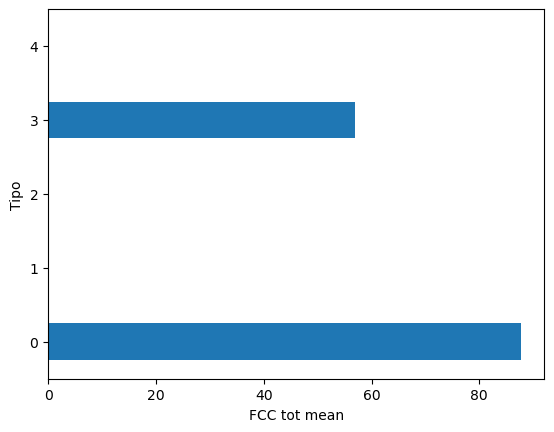

In [ ]:
print(pcparcelas_3.groupby(['Tipo']).count()['Estadillo'])
pcparcelas_3.groupby(['Tipo'])['FccTot'].mean().plot(kind="barh", xlabel="FCC tot mean")

Tipo
0    4915
1      33
2       5
3      50
Name: Estadillo, dtype: int64


<Axes: xlabel='FCC tot mean', ylabel='Tipo'>

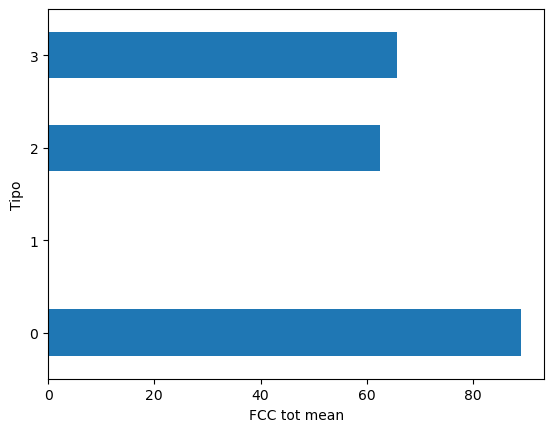

In [33]:
print(pcparcelas_4.groupby(['Tipo']).count()['Estadillo'])
pcparcelas_4.groupby(['Tipo'])['FccTot'].mean().plot(kind="barh", xlabel="FCC tot mean")

### Usos de suelo

Nivel 1:

- Monte / Forestal (1) Superficie con especies arbóreas, arbustivas, de matorral o herbáceas (naturales o repoblación) excepto cultivos.
- Agrícola (2) Territorio con herbáceas y/o leñosas que se laborea con una fuerte intervención humana.
- Artificial (3) Dominado por edificios, parques urbanos (aunque estén
poblados de arboles) u otras construcciones humanas.
- Humedal (4) Lo constituyen las lagunas, charcas, zonas húmedas, marismas y corrientes discontinuas de agua.
- Agua (5) Tierra constituida por ríos, lagos, embalses, canales o estanques con superficies continuas de más de 0,25 ha y con agua prácticamente todo el año.

Nivel 2 (solo aquellos con uso forestal de Nivel 1 == 1):

- Monte arbolado (1) Territorio con especies forestales arbóreas como estructura vertical dominante (FCC >= 20%)
- Monte arbolado ralo (2) Especies arbóreas forestales (FCC >= 10 y FCC < 20) pero que puede presentar un dominio de especies de matorral o pastizal natural, pero con una presencia de árboles forestales importante.
- Monte temporalmente desarbolado (3) Área que en el pasado cercano era monte arbolado y actualmente está desprovisto de árboles opero que, casi con seguridad, en el futuro próximo volverá a estar cubierto de ellos.
- Monte desarbolado (4) Terreno poblado con especies de matorral o/y pastizal natural como manifestación vegetal dominante. Puede haber o no presencia de
árboles forestales (FCC < 5%)
- Monte sin vegetación superior (5) Terreno situado en zona de uso forestal pero sin vegetales superiores, aunque sí podría estarlo por vegetales inferiores o aparecer sin cubierta vegetal alguna.
- Árboles fuera del monte (6) Riberas pobladas de árboles que no sean plantaciones situadas fuera de los montes, bosquetes de menos de 2.500 m2 de cabida, las alineaciones de especies arbóreas o arbustivas de anchura menor de 25 m y los árboles sueltos situados sobre algún terreno de uso forestal.
- Monte desarbolado con arbolado disperso (7) Terreno con especies de
matorral o pastizal natural como manifestación vegetal dominante, pero presencia de árboles forestales importante (FCC >= 5% y FCC < 10%).

Nivel 3:

Monte arbolado (Nivel 2 == 1):

- Bosque (1) Estructura de árboles, arbustos y otros vegetales con escasa influencia del ser humano. 
- Bosque de plantaciones (2) Estructura de árboles bien solos o acompañados de arbustos y otros vegetales pero con predominio absoluto del estrato arbóreo. Su origen es artificial.
- Bosque adehesado (3). Estructura de árboles y arbustos con cultivos herbáceos y pastizales y un uso agro-silvo-pastoral.
- Complementos del bosque (4). Terrenos que no siendo bosques están al servicio de ellos (pistas forestales, cortafuegos, parques de madera...).

Monte arbolado ralo (Nivel 2 == 2): Mismas categorías que el Monte arbolado, sustituyendo monte arbolado por monte arbolado ralo.

Monte temporalmente desarbolado (Nivel 2 == 3):

- Talas (1) Debido a cortas efectuadas por el hombre.
- Incendios (2). Dbido al fuego (provocado por intervención humana o natural).
- Fenómenos naturales (3) Sucesos naturales (excepto incendios) (e.g. inundaciones, corrimientos de tierra, aludes de nieve)

Se seleccionan los de Nivel 1 == 1, y dentro de esta categoría:

- Nivel 2 == 1 para las etiquetas de vegetación forestal.
- Nivel 2 clases 2-5 para seleccionar especies de vegetación arbustiva.

Dentro del Nivel 2 == 3, se selecciona únicamente la clase 2 (incendios).

No se seleccionan los complementos de bosque ni el bosque adehesado en las categorías de Nivel 2 == 1 | 2.

In [99]:
queries = {
    'shrubs': "Nivel1 == '1' and (Nivel2 in ['2', '4']) and (Nivel3 in ['1', '2'])",
    'forest': "Nivel1 == '1' and Nivel2 == '1' and (Nivel3 in ['1', '2'])",
    'burned': "Nivel1 == '1' and Nivel2 == '3' and (Nivel3 == '2')"
}

niv_cols = ['Nivel1', 'Nivel2', 'Nivel3']

for k, v in queries.items():
    print(k)
    print(pcparcelas_3.query(v).groupby(niv_cols).count()["Estadillo"])

shrubs
Nivel1  Nivel2  Nivel3
1       2       1         205
                2          24
Name: Estadillo, dtype: int64
forest
Nivel1  Nivel2  Nivel3
1       1       1         4698
                2          732
Name: Estadillo, dtype: int64
burned
Nivel1  Nivel2  Nivel3
1       3       2         9
Name: Estadillo, dtype: int64


In [100]:
for k, v in queries.items():
    print(k)
    print(pcparcelas_4.query(v).groupby(niv_cols).count()["Estadillo"])

shrubs
Nivel1  Nivel2  Nivel3
1       2       1         168
                2          16
        4       1           3
                2           1
Name: Estadillo, dtype: int64
forest
Nivel1  Nivel2  Nivel3
1       1       1         3937
                2          628
Name: Estadillo, dtype: int64
burned
Nivel1  Nivel2  Nivel3
1       3       2         9
Name: Estadillo, dtype: int64


## Ifn / PCEspParc

Seleccionar la primera especie de la parcela. Se seleccionan solo las especies en la primera posición en los estadillos seleccionados en la table PCParcelas.

In [190]:
# Cols from PCParcelas
pcparcelas_cols = ['PCParcelas.' + c for c in ['Estadillo', 'Provincia']]
# Cols from PCEspParc
pcesp_cols = ['PCEspParc.' + c for c in ['Ocupa', 'Especie']]
# Construct the select query.
select_cols = pcparcelas_cols + pcesp_cols

# Create WHERE statement
where = ' AND '.join([
  'PCParcelas.Subclase <> \'3E\'',
  'PCEspParc.PosEsp = \'1\'',
  'PCEspParc.Subclase <> \'3E\''
])
# Create the JOIN
join_sql = 'INNER JOIN PCEspParc ON PCParcelas.Estadillo=PCEspParc.Estadillo'

pcesp_3 = ifn3.open('PCParcelas', where=where, join=join_sql, cols=select_cols)
pcesp_4 = ifn4.open('PCParcelas', where=where, join=join_sql, cols=select_cols)

In [191]:
join_c = ["Estadillo", "Provincia"]
pcparcelas_3_prun = pcesp_3.join(pcparcelas_3.set_index(join_c), on=join_c)
pcparcelas_4_prun = pcesp_4.join(pcparcelas_4.set_index(join_c), on=join_c)

In [ ]:
pcparcelas_3_prun["Especie"] = erase_zeros(pcparcelas_3_prun, "Especie")
pcparcelas_4_prun["Especie"] = erase_zeros(pcparcelas_4_prun, "Especie")

In [193]:
esp_codes_path = Path(ROOT, r"data\labels\label_codes.csv")
esp_codes_df = pd.read_csv(esp_codes_path)

def species_join(df):
    joined = df.join(esp_codes_df.set_index("code_ifn"), on="Especie")
    # Select valid vegetation types
    return joined.query("label.notna()")

pcparcelas_3_prun = species_join(pcparcelas_3_prun)
pcparcelas_4_prun = species_join(pcparcelas_4_prun)

<Axes: ylabel='label'>

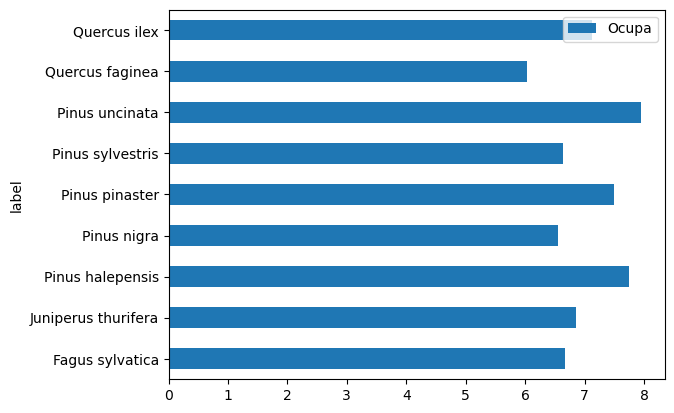

In [227]:
pcparcelas_3_prun.groupby('label')["Ocupa"].mean().reset_index().plot(kind="barh", y="Ocupa", x="label")

## Conclusiones

Se seleccionan estadillos por las mismas métricas y umbrales que en el IFN2 para mantener la coherencia.

Los puntos de matorral se seleccionan en función de las columnas con los usos de suelo (`Nivel*`) 

De la misma forma que en el IFN2, también se seleccionan aquellos puntos que se sitúan en una zona quemada hace no más de diez años. En el IFN4, realizado en 2021, se utilizan incendios de entre 2011 y 2020. En el caso del IFN3, se realiza un filtrado iterativo entre los años de elaboración (2002 a 2005).

Se seleccionan primero los puntos de matorral, evitando así que se vuelvan a incluir en puntos con vegetación forestal.

In [2]:
# Include COORDINATES inside each ifn database
coord_path = Path(ROOT, "data/labels/ifn/coordinates/IFN4_crs_oficial.csv")
coord = pd.read_csv(coord_path)
coord = coord[['provincia', 'estadillo', 'X_WGS84_4326', 'Y_WGS84_4326']]

def add_crs(df, crs: pd.DataFrame):
    """Add point X,Y of each IFN point"""
    df_cols = ['Estadillo', 'Provincia']
    df_crs = df.join(crs.set_index(['estadillo', 'provincia']), on = df_cols)
    # Create a geodataframe object
    x_col = "X_WGS84_4326"
    y_col = "Y_WGS84_4326"
    crs = 'EPSG:4326'
    geom = gpd.points_from_xy(
        df_crs[x_col], df_crs[y_col], crs=crs)
    data = gpd.GeoDataFrame(df_crs, geometry=geom)
    return data.query("X_WGS84_4326.notnull()")

In [3]:
# Add species codes
esp_codes_path = Path(ROOT, r"data\labels\label_codes.csv")
esp_codes_df = pd.read_csv(esp_codes_path)

def species_join(df):
    joined = df.join(esp_codes_df.set_index("code_ifn"), on="Especie")
    # Select valid vegetation types
    return joined.query("label.notna()")

In [4]:
# Start all the filtering process again to avoid errors
ifn3 = Modern(Path(ROOT, r"data\labels\ifn\ifn3"))
ifn4 = Modern(Path(ROOT, r"data\labels\ifn\ifn4"))

In [5]:
def get_forest_labels(ifn: Modern, number):
    
    pcparcelas_cols = [
        'Provincia',
        'Estadillo',
        'FechaFin',
        'FccArb'
    ]

    pcesp_cols = ["Especie", "Ocupa"]

    # Prepare data for the query
    cols = ['PCParcelas.' + c for c in pcparcelas_cols]
    # Cols from PCEspParc
    select = cols + ['PCEspParc.' + c for c in pcesp_cols]

    # Create WHERE statement
    where = ' AND '.join([
        'PCParcelas.Subclase <> \'3E\'',
        # Parcela normal
        'PCParcelas.Tipo = \'0\'',
        'PCParcelas.FccArb > 20',
        'PCParcelas.Nivel1 = \'1\'',
        'PCParcelas.Nivel2 = \'1\'',
        'PCEspParc.PosEsp = \'1\'',
        'PCEspParc.Ocupa >= 4',
        'PCEspParc.Subclase <> \'3E\''
    ])

    # Create the JOIN
    join = 'INNER JOIN PCEspParc ON PCParcelas.Estadillo=PCEspParc.Estadillo'

    data = ifn.open('PCParcelas', cols=select, where=where, join=join)
    # Erase the leading 0s in Estadillo column (matching the IFN2 style)
    data["Estadillo"] = erase_zeros(data, "Estadillo")
    # And in Especie column
    data["Especie"] = erase_zeros(data, "Especie")

    # Add a column with the NFI name
    data["source"] = f"NFI{str(number)}"
    return data

In [8]:
forest_labels = pd.concat(
    [get_forest_labels(ifn3,3), get_forest_labels(ifn4,4)])
forest_labels = add_crs(forest_labels, coord)
forest_labels = species_join(forest_labels)
# There are several rows with no date values
forest_labels = forest_labels.dropna()

In [9]:
def get_shrub_labels(ifn: Modern, number):
    
    pcparcelas_cols = [
        'Provincia',
        'Estadillo',
        'FechaFin',
        'Nivel1',
        'Nivel2',
        'FccArb'
    ]

    pcesp_cols = ["Especie", 'Ocupa']

    # Prepare data for the query
    cols = ['PCParcelas.' + c for c in pcparcelas_cols]
    # Cols from PCEspParc
    select = cols + ['PCEspParc.' + c for c in pcesp_cols]

    # Create WHERE statement
    where = ' AND '.join([
        'PCParcelas.Subclase <> \'3E\'',
        'PCEspParc.PosEsp = \'1\'',
        'PCEspParc.Subclase <> \'3E\''
    ])

    # Create the JOIN
    join = 'INNER JOIN PCEspParc ON PCParcelas.Estadillo=PCEspParc.Estadillo'

    data = ifn.open('PCParcelas', cols=select, where=where, join=join)
    # Erase the leading 0s in Estadillo column (matching the IFN2 style)
    data["Estadillo"] = erase_zeros(data, "Estadillo")
    # And in Especie column
    data["Especie"] = erase_zeros(data, "Especie")

    # Add a column with the NFI name
    data["source"] = f"NFI{str(number)}"

    return data

In [10]:
shrub_labels = pd.concat([get_shrub_labels(ifn3,3), get_shrub_labels(ifn4,4)])
shrub_labels = add_crs(shrub_labels, coord)
shrub_labels = species_join(shrub_labels)

In [11]:
# From all the above target shrub points, select shrub data by:
# 1. Points within fire perimeters
fires_path = Path(ROOT, "data/fires.gpkg")
fires = gpd.read_file(fires_path) # EPSG:4326
fires["Year"] = fires["Year"].astype("int16")

def filter_by_year(df, fires, year):
    df_fires = gpd.sjoin(df, fires, how="inner", predicate="within")
    # Filter by fire year
    return df_fires.query(f"Year >= {year-10} and Year <= {year-1}")

burned_shrub = []
for y in [2002, 2004, 2005]:
    burned_shrub.append(filter_by_year(shrub_labels, fires, y))
burned_shrub = pd.concat(burned_shrub)

In [12]:
burned_shrub.shape

(339, 38)

In [13]:
# 2. Plots with land cover as shrub type (all but forest)
cover_shrub = shrub_labels.query("Nivel1 == '1' and Nivel2 != '1'")

In [14]:
cover_shrub.shape

(280, 18)

Muchos de los estadillos que se sitúan sobre un área quemada poco tiempo atrás están enmarcados en los tipos de matorral.

In [15]:
# Keep the first occurrence and drop the others with the same values in cols
cols = ["Estadillo", "Provincia"]
shrub_labels = pd.concat([burned_shrub, cover_shrub])
shrub_labels = shrub_labels.drop_duplicates(subset=cols)
shrub_labels.shape

(278, 38)

In [16]:
# Update the label code to point shrub labels
shrub_labels["code_v1"] = shrub_labels["code_v1"] + 10

In [17]:
print(shrub_labels["code_v1"].value_counts().sort_index())

code_v1
11.0    124
12.0     16
13.0      4
14.0     19
15.0      2
16.0     37
17.0     53
19.0     23
Name: count, dtype: int64


In [18]:
def joining_ifn(forest_df, shrub_df):
    # Merge two kind of labels
    merge = pd.concat([forest_df, shrub_df]).reset_index()
    # Remove duplicates and maintain the shrub one
    # Sort so that rows with shrub labels 5 come first
    cols = ["Estadillo", "Provincia"]
    merge.sort_values(by='code_v1', ascending=False)['code_v1']
    # For each group of duplicates, keep the first occurrence (shrub label)
    merge = merge.drop_duplicates(subset=cols, keep='first')
    return merge

points = joining_ifn(forest_labels, shrub_labels)

In [19]:
# Add a year column (avoid "year" name due to there is the same key in fire df)
points["ANO"] = points['FechaFin'].dt.year

In [21]:
points.columns

Index(['index', 'Provincia', 'Estadillo', 'FechaFin', 'FccArb', 'Especie',
       'Ocupa', 'source', 'X_WGS84_4326', 'Y_WGS84_4326', 'geometry',
       'code_v1', 'code_v1_reclass', 'label', 'label_reclass', 'label_rc_code',
       'color', 'Nivel1', 'Nivel2', 'index_right', 'IDPIF', 'PROV', 'MUN_1',
       'MUN_2', 'MUN_3', 'FECHA', 'FUENTE', 'ID_AGRUPAC', 'SBTP', 'SS00Z',
       'SSTIPO', 'FACTORBASI', 'INCENTIPO', 'EPOCA', 'PERIMETER', 'Year',
       'Fire_ID', 'IDPAF', 'Sup_FO', 'ANO'],
      dtype='object')

In [20]:
# Export data
cols_to_keep = [
    "Estadillo", "Provincia", "ANO", "code_v1", "source", "FccArb", "Ocupa", "geometry"]
# Rename columns
df = points[cols_to_keep].rename(columns={
    'ANO': 'YEAR',
    'code_v1': 'ESPE',
    'FccArb': 'FCC',
    'Ocupa': 'Ocu1'
})

# Export labels by NFI
for nfi in df["source"].unique():
    nfi_number = nfi[-1]
    out_path = Path(ROOT, f"data/labels/ifn{nfi_number}_labels.gpkg")
    df.query(f"source == '{nfi}'").to_file(out_path)